### <span style="color:darkorange">**Riiid - ensemble**</span>

In [1]:
import pickle
from tqdm import tqdm

import torch
import pandas as pd
import numpy as np

import pylab
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
import lightgbm

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data container
with open("./targets_trans.pt", "rb") as handle:
    targets_trans = pickle.load(handle).numpy()
# load data container
with open("./preds_trans.pt", "rb") as handle:
    preds_trans = pickle.load(handle).numpy()

# load data container
with open("./targets_lstm.pt", "rb") as handle:
    targets_lstm = pickle.load(handle).numpy()
# load data container
with open("./preds_lstm.pt", "rb") as handle:
    preds_lstm = pickle.load(handle).numpy()

# load data container
with open("./targets_gru.pt", "rb") as handle:
    targets_gru = pickle.load(handle).numpy()
# load data container
with open("./preds_gru.pt", "rb") as handle:
    preds_gru = pickle.load(handle).numpy()
    

In [3]:
trans_score = round(roc_auc_score(targets_gru, preds_trans), 5)
lstm_score = round(roc_auc_score(targets_lstm, preds_lstm), 5)
gru_score = round(roc_auc_score(targets_gru, preds_gru), 5)
print(f"Transformer score: {trans_score}")
print(f"LSTM score: {lstm_score}")
print(f"GRU score: {gru_score}")

Transformer score: 0.80956
LSTM score: 0.8063
GRU score: 0.80598


In [4]:
# probability based ensemble: (LSTM + GRU)
preds_ensemble_p = 0.5*preds_lstm + 0.5*preds_gru
print(f"Probability ensemble: {round(roc_auc_score(targets_lstm, preds_ensemble_p), 5)}")

Probability ensemble: 0.80754


In [5]:
# probability based ensemble: (Transformer + LSTM + GRU)
preds_ensemble_p = 0.6*preds_trans + 0.2*preds_lstm + 0.2*preds_gru
print(f"Probability ensemble: {round(roc_auc_score(targets_gru, preds_ensemble_p), 5)}")

Probability ensemble: 0.81125


In [7]:
# Linear regression based ensemble: (Transformer + LSTM + GRU)
preds_ensemble_p = 0.0001394987 + 0.6751157*preds_trans + 0.16328987*preds_lstm + 0.16169962*preds_gru
print(f"Probability ensemble: {round(roc_auc_score(targets_gru, preds_ensemble_p), 5)}")

Probability ensemble: 0.81118


In [6]:
# ranked based ensemble: (Transformer + LSTM + GRU)
preds_trans_r = pd.Series(preds_trans).rank()
preds_lstm_r = pd.Series(preds_lstm).rank()
preds_gru_r = pd.Series(preds_gru).rank()
preds_ensemble_r = 0.0001394987 + 0.6751157*preds_trans_r + 0.16328987*preds_lstm_r + 0.16169962*preds_gru_r
print(f"Ranked ensemble: {round(roc_auc_score(targets_gru, preds_ensemble_r), 5)}")

Ranked ensemble: 0.81127


### Finding the best ensembling method

In [11]:
# as array
X_a = np.stack((preds_trans, preds_lstm, preds_gru), axis=1)
y_a = np.expand_dims(targets_trans, axis=1)
# as df
X_p = pd.DataFrame(X_a, columns=["transformer", "lstm", "gru"])
y_p = pd.DataFrame(y_a, columns=["y"])

print(X_p.shape)
print(y_p.shape)

(2464814, 3)
(2464814, 1)


In [12]:
X_p.corr()

,transformer,lstm,gru
transformer,1.000000,0.960926,0.959932
lstm,0.960926,1.000000,0.981396
gru,0.959932,0.981396,1.000000


In [13]:
X_p.head()

,transformer,lstm,gru
0,0.434822,0.432731,0.448576
1,0.250913,0.218359,0.234810
2,0.089661,0.092552,0.122791
3,0.305984,0.313508,0.334713
4,0.162253,0.143597,0.148210


### Linear regression - old method

1. make a 5-fold split
2. train 5 linear models
3. ensembling model is average of those 5

In [17]:
# Linear Regression

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# lists to store model's parameters across different folds
coefs = []
intercepts = []

for e, (train_index, val_index) in enumerate(kf.split(X_a)):
    
    # split the data
    X_train, X_val = X_a[train_index], X_a[val_index]
    y_train, y_val = y_a[train_index], y_a[val_index]
    
    # fit the model
    lr_model = LinearRegression().fit(X_train, y_train)
    
    # get predictions
    train_score = round(roc_auc_score(y_train, lr_model.predict(X_train)), 5)
    val_score = round(roc_auc_score(y_val, lr_model.predict(X_val)), 5)    
    
    print(f"Fold {e} / train: {train_score} / val: {val_score}")
        
    coefs.append(lr_model.coef_)
    intercepts.append(lr_model.intercept_)

intercept = np.mean(np.asarray(intercepts), axis=0)
weights = np.mean(np.asarray(coefs), axis=0)
print(f"\nFinal model: {intercept[0]} + {weights[0, 0]} * trans + {weights[0, 1]} * lstm + {weights[0, 2]} * gru")

preds_all = intercept[0] + weights[0, 0] * preds_trans + weights[0, 1] * preds_lstm + weights[0, 2] * preds_gru
print(f"\nFinal score: {round(roc_auc_score(targets_lstm, preds_all), 5)}")

Fold 0 / train: 0.81131 / val: 0.81098
Fold 1 / train: 0.81117 / val: 0.81156
Fold 2 / train: 0.8114 / val: 0.81064
Fold 3 / train: 0.81103 / val: 0.81212
Fold 4 / train: 0.81132 / val: 0.81094

Final model: -0.000980460667051375 + 0.5971253514289856 * trans + 0.21422846615314484 * lstm + 0.19049938023090363 * gru

Final score: 0.81125


### Linear Regression new method

In [18]:
def get_lr_improvement(random_state):
    
    X_train, X_val, y_train, y_val, trans_train, trans_val = train_test_split(X_a, y_a, preds_trans, test_size=0.2, random_state=random_state)

    # fit the model
    lr_model = LinearRegression().fit(X_train, y_train)
    
    # get predictions
    train_score = round(roc_auc_score(y_train, lr_model.predict(X_train)), 5)
    val_score = round(roc_auc_score(y_val, lr_model.predict(X_val)), 5)
    
    train_imp = train_score - roc_auc_score(y_train, trans_train)
    val_imp = val_score - roc_auc_score(y_val, trans_val)
    
    return train_imp, val_imp
    

In [19]:
train_imp_a = []
val_imp_a = []

for random_state in tqdm(range(64)):
    
    train_imp, val_imp = get_lr_improvement(random_state)
    
    train_imp_a.append(train_imp)
    val_imp_a.append(val_imp)

train_imp_a = np.asarray(train_imp_a)
val_imp_a = np.asarray(val_imp_a)

100%|██████████| 64/64 [02:47<00:00,  2.61s/it]


In [21]:
train_mean = np.round(np.mean(train_imp_a), 5)
val_mean = np.round(np.mean(val_imp_a), 5)
train_std = np.round(np.std(train_imp_a), 5)
val_std = np.round(np.std(val_imp_a), 5)

print(f"Mean train improvement / {train_mean} / std / {train_std}")
print(f"Mean val improvement / {val_mean} / std / {val_std}")

Mean train improvement / 0.00169 / std / 1e-05
Mean val improvement / 0.00167 / std / 6e-05


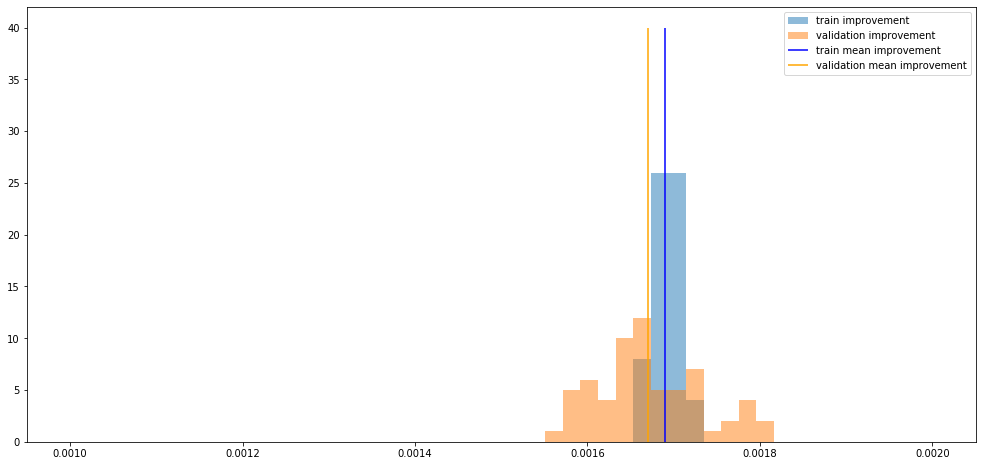

In [24]:
# plot train and 

plt.rcParams["figure.figsize"] = (17, 8)
bins = np.linspace(0.001, 0.002, 50)

plt.hist(train_imp_a, bins=bins, alpha=0.5, label="train improvement")
plt.hist(val_imp_a, bins=bins, alpha=0.5, label="validation improvement")
plt.vlines(train_mean, ymin=0, ymax=40, colors='blue', label='train mean improvement')
plt.vlines(val_mean, ymin=0, ymax=40, colors='orange', label='validation mean improvement')
plt.legend(loc="upper right")
plt.show()

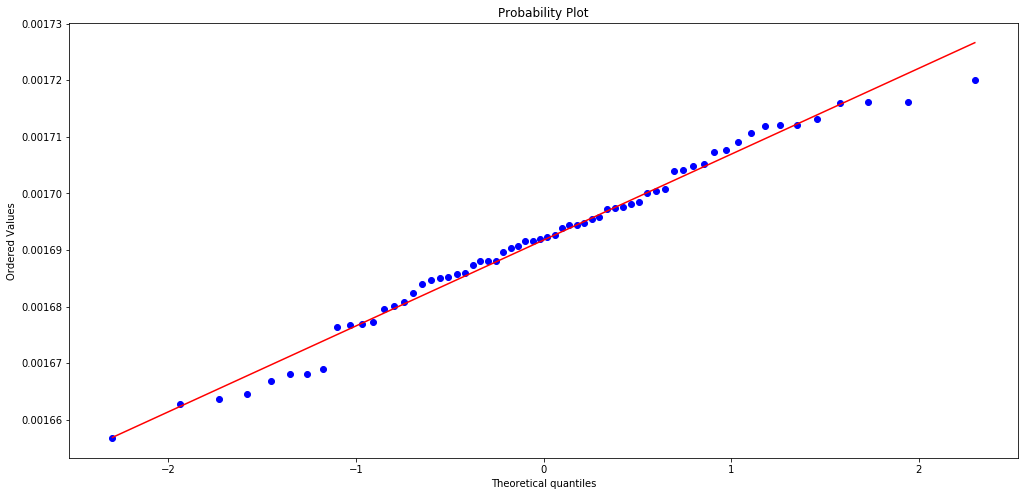

In [25]:
# train scores normality test
stats.probplot(train_imp_a, dist="norm", plot=pylab)
pylab.show()

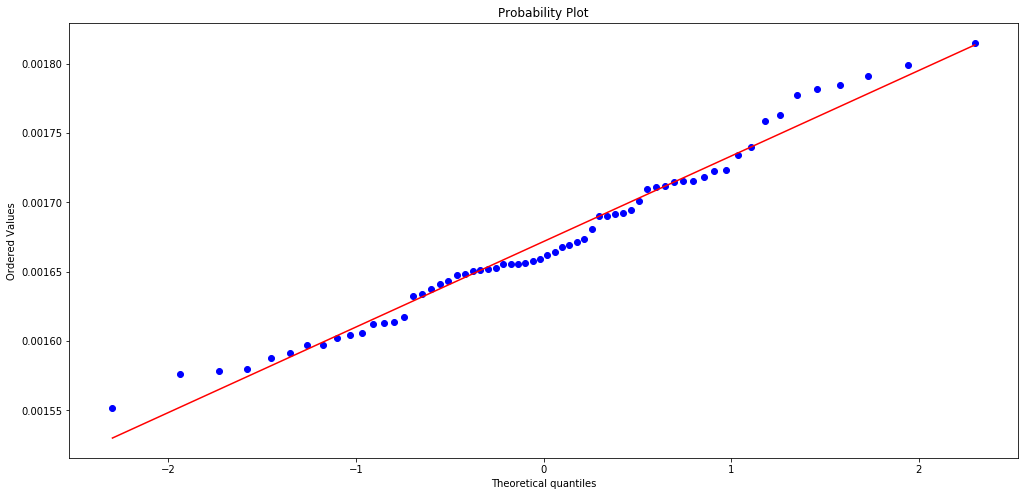

In [26]:
# validation normality test
stats.probplot(val_imp_a, dist="norm", plot=pylab)
pylab.show()

### LGMB

In [27]:
def get_lgbm_improvement(random_state):
    
    X_train, X_val, y_train, y_val, trans_train, trans_val = train_test_split(X_a, y_a, preds_trans, test_size=0.2, random_state=random_state)

    # fit the model
    lgbm_model = LGBMRegressor(n_estimators=50, num_leaves=10, max_depth=20).fit(X_train, y_train)
    
    # get predictions
    train_score = round(roc_auc_score(y_train, lgbm_model.predict(X_train)), 5)
    val_score = round(roc_auc_score(y_val, lgbm_model.predict(X_val)), 5)
    
    train_imp = train_score - roc_auc_score(y_train, trans_train)
    val_imp = val_score - roc_auc_score(y_val, trans_val)
        
    return train_imp, val_imp
    

In [28]:
train_imp_a = []
val_imp_a = []

for random_state in tqdm(range(64)):
    
    train_imp, val_imp = get_lgbm_improvement(random_state)
    
    train_imp_a.append(train_imp)
    val_imp_a.append(val_imp)

train_imp_a = np.asarray(train_imp_a)
val_imp_a = np.asarray(val_imp_a)

100%|██████████| 64/64 [05:09<00:00,  4.84s/it]


In [29]:
train_mean = np.round(np.mean(train_imp_a), 5)
val_mean = np.round(np.mean(val_imp_a), 5)
train_std = np.round(np.std(train_imp_a), 5)
val_std = np.round(np.std(val_imp_a), 5)

print(f"Mean train improvement / {train_mean} / std / {train_std}")
print(f"Mean val improvement / {val_mean} / std / {val_std}")

Mean train improvement / 0.0023 / std / 2e-05
Mean val improvement / 0.00214 / std / 7e-05


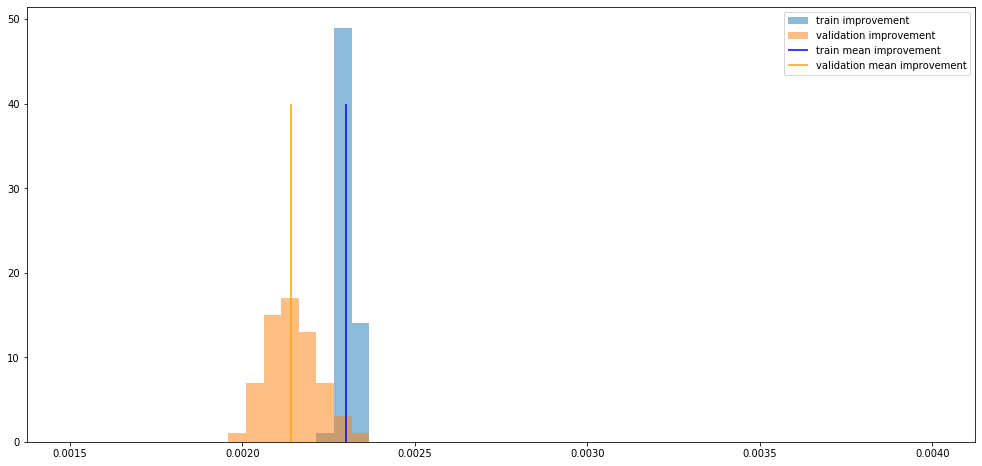

In [33]:
# plot train and 

plt.rcParams["figure.figsize"] = (17, 8)
bins = np.linspace(0.0015, 0.004, 50)

plt.hist(train_imp_a, bins=bins, alpha=0.5, label="train improvement")
plt.hist(val_imp_a, bins=bins, alpha=0.5, label="validation improvement")
plt.vlines(train_mean, ymin=0, ymax=40, colors='blue', label='train mean improvement')
plt.vlines(val_mean, ymin=0, ymax=40, colors='orange', label='validation mean improvement')
plt.legend(loc="upper right")
plt.show()

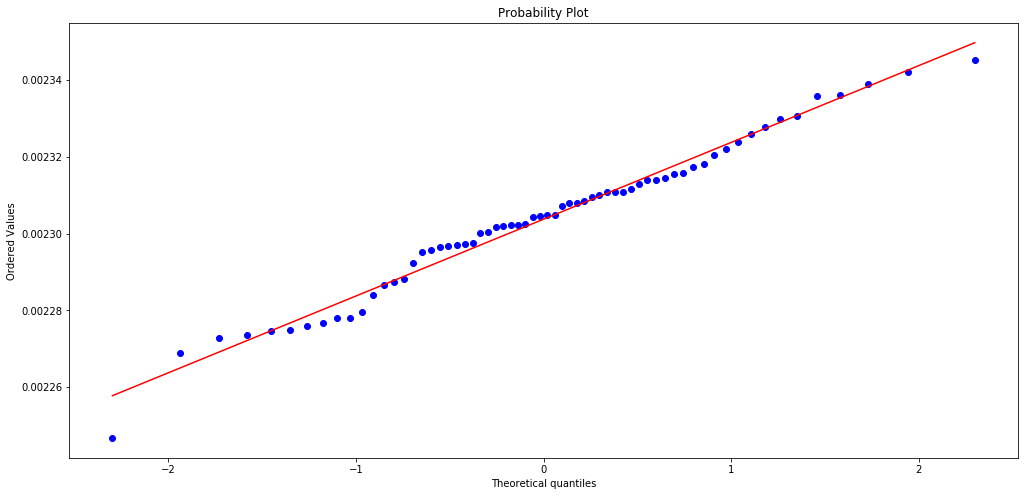

In [34]:
# train scores normality test
stats.probplot(train_imp_a, dist="norm", plot=pylab)
pylab.show()

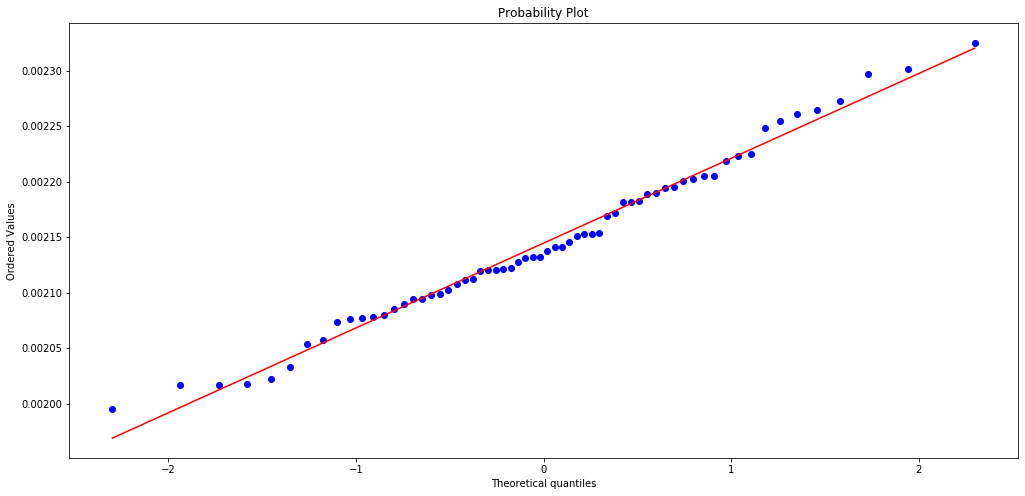

In [35]:
# validation normality test
stats.probplot(val_imp_a, dist="norm", plot=pylab)
pylab.show()

In [ ]:
# # TRAIN AND SAVE MODEL ON FULL DATASET
# lgbm_model = LGBMRegressor(n_estimators=50, num_leaves=10, max_depth=20).fit(X_a, y_a)
# with open("model_lgbm.pickle", "wb") as handle:
#     pickle.dump(lgbm_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
